In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

In [2]:
class Generator(nn.Module):
    # z_dim is the size of the input random noise vector
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, 256) # Project noise to 256-dim
        self.fc2 = nn.Linear(256, 512) # Expand to 512-dim
        self.fc3 = nn.Linear(512, 1024) # Expand to 1024-dim
        self.fc4 = nn.Linear(1024, 28*28) # Output size = image size

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, z):
        z = self.fc1(z)
        z = self.relu(z)
        z = self.fc2(z)
        z = self.relu(z)
        z = self.fc3(z)
        z = self.relu(z)
        z = self.fc4(z)
        z = self.tanh(z).view(-1, 1, 28, 28)  # Output values in range [-1, 1] & Reshape to image format
        return z

In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(28*28, 1024) # First hidden layer
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 1) # Single output neuron representing the probability of the input image being real or fake

        self.leaky_relu = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, img):
        x = img.view(-1, 28*28)  # Flatten the image
        x = self.fc1(x)
        x = self.leaky_relu(x)
        x = self.fc2(x)
        x = self.leaky_relu(x)
        x = self.fc3(x)
        x = self.leaky_relu(x)
        x = self.fc4(x)
        x = self.sigmoid(x)  # Normalize the output to the range  [0,1]
        return x

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [6]:
dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

In [7]:
z_dim = 100  # Latent vector size

# Initializing the Generator and Discriminator classes
generator = Generator(z_dim).to(device)
discriminator = Discriminator().to(device)

In [8]:
loss_func = nn.BCELoss() # Binary Cross-Entropy Loss

optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [9]:
num_epochs = 30

for epoch in range(num_epochs):
    running_d_loss = 0.0
    running_g_loss = 0.0
    for real_images, _ in dataloader:

        real_images = real_images.to(device)
        current_batch_size = real_images.size(0)

        # Adversarial ground truths with dynamic batch size
        real_labels = torch.ones(current_batch_size, 1).to(device)
        fake_labels = torch.zeros(current_batch_size, 1).to(device)

        # Train the Discriminator
        optimizer_d.zero_grad()

        # Real images
        outputs = discriminator(real_images)
        d_loss_real = loss_func(outputs, real_labels)

        # Fake images
        z = torch.randn(current_batch_size, z_dim).to(device)  # Use current batch size for latent vector
        fake_images = generator(z)
        outputs = discriminator(fake_images.detach())
        d_loss_fake = loss_func(outputs, fake_labels)

        # Backpropagation for Discriminator
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_d.step()

        # Train the Generator
        generator.zero_grad()

        # Try to fool the discriminator with fake images
        outputs = discriminator(fake_images)
        g_loss = loss_func(outputs, real_labels)

        # Backpropagation for Generator
        g_loss.backward()
        optimizer_g.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}')

print('Training complete!')

Epoch [1/30], d_loss: 0.26079675555229187, g_loss: 6.153631210327148
Epoch [2/30], d_loss: 1.582282304763794, g_loss: 3.518700361251831
Epoch [3/30], d_loss: 0.2529602348804474, g_loss: 2.684633731842041
Epoch [4/30], d_loss: 0.5532546043395996, g_loss: 2.4021286964416504
Epoch [5/30], d_loss: 0.47485223412513733, g_loss: 2.034524917602539
Epoch [6/30], d_loss: 0.8701634407043457, g_loss: 2.686154365539551
Epoch [7/30], d_loss: 0.5976460576057434, g_loss: 2.468398094177246
Epoch [8/30], d_loss: 0.7555012702941895, g_loss: 1.800168752670288
Epoch [9/30], d_loss: 0.7872039079666138, g_loss: 1.5985112190246582
Epoch [10/30], d_loss: 0.8754875659942627, g_loss: 1.420307993888855
Epoch [11/30], d_loss: 0.7836971879005432, g_loss: 1.697767734527588
Epoch [12/30], d_loss: 0.8405361175537109, g_loss: 2.1714015007019043
Epoch [13/30], d_loss: 1.1453300714492798, g_loss: 1.9192144870758057
Epoch [14/30], d_loss: 1.065962791442871, g_loss: 1.1625584363937378
Epoch [15/30], d_loss: 0.8382141590118

In [10]:
torch.save({
    'generator_state_dict': generator.state_dict(), # Saves the weights of the Generator
    'discriminator_state_dict': discriminator.state_dict(), # Saves the weights of the Discriminator
    'optimizer_g_state_dict': optimizer_g.state_dict(), # Saves the Generator optimizer state
    'optimizer_d_state_dict': optimizer_d.state_dict() # Saves the Discriminator optimizer state
}, 'mnist_GAN.pt')

print("Model saved!")

Model saved!


In [11]:
GAN_Model = torch.load('mnist_GAN.pt')

# Re-initialize models and optimizers
generator = Generator(z_dim)  # Ensure img_dim=784

# Load model weights
generator.load_state_dict(GAN_Model['generator_state_dict'])

# Load optimizers (if continuing training)
optimizer_g = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))

optimizer_g.load_state_dict(GAN_Model['optimizer_g_state_dict'])

generator.eval()

print("Generator loaded successfully!")

Generator loaded successfully!


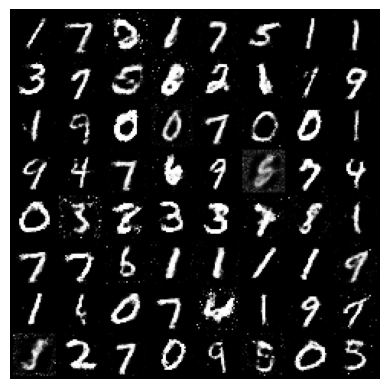

In [12]:
import matplotlib.pyplot as plt

# Generate random noise and use the generator to produce images
z = torch.randn(64, z_dim)
generated_imgs = generator(z).view(-1, 1, 28, 28)

# Create a grid of the generated images
grid_img = torchvision.utils.make_grid(generated_imgs, nrow=8, padding=2, normalize=True)

# Display the images
plt.imshow(grid_img.permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')
plt.axis('off')
plt.show()

# CIFAR10

In [54]:
class Generator(nn.Module):
    # z_dim is the size of the input random noise vector
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, 256) # Project noise to 256-dim
        self.fc2 = nn.Linear(256, 512) # Expand to 512-dim
        self.fc3 = nn.Linear(512, 1024) # Expand to 1024-dim
        self.fc4 = nn.Linear(1024, 32*32*3) # Output size = image size

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, z):
        z = self.fc1(z)
        z = self.relu(z)
        z = self.fc2(z)
        z = self.relu(z)
        z = self.fc3(z)
        z = self.relu(z)
        z = self.fc4(z)
        z = self.tanh(z).view(-1, 3, 32, 32)  # Output values in range [-1, 1] & Reshape to image format
        return z

In [55]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 1024) # First hidden layer
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 1) # Single output neuron representing the probability of the input image being real or fake

        self.leaky_relu = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, img):
        x = img.view(-1, 32*32*3)  # Flatten the image
        x = self.fc1(x)
        x = self.leaky_relu(x)
        x = self.fc2(x)
        x = self.leaky_relu(x)
        x = self.fc3(x)
        x = self.leaky_relu(x)
        x = self.fc4(x)
        x = self.sigmoid(x)  # Normalize the output to the range  [0,1]
        return x

In [56]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [57]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [58]:
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

Files already downloaded and verified


In [59]:
z_dim = 100  # Latent vector size

# Initializing the Generator and Discriminator classes
generator = Generator(z_dim).to(device)
discriminator = Discriminator().to(device)

In [60]:
loss_func = nn.BCELoss() # Binary Cross-Entropy Loss

optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [61]:
num_epochs = 30

for epoch in range(num_epochs):
    running_d_loss = 0.0
    running_g_loss = 0.0
    for real_images, _ in dataloader:

        real_images = real_images.to(device)
        current_batch_size = real_images.size(0)

        # Adversarial ground truths with dynamic batch size
        real_labels = torch.ones(current_batch_size, 1).to(device)
        fake_labels = torch.zeros(current_batch_size, 1).to(device)

        # Train the Discriminator
        optimizer_d.zero_grad()

        # Real images
        outputs = discriminator(real_images)
        d_loss_real = loss_func(outputs, real_labels)

        # Fake images
        z = torch.randn(current_batch_size, z_dim).to(device)  # Use current batch size for latent vector
        fake_images = generator(z)
        outputs = discriminator(fake_images.detach())
        d_loss_fake = loss_func(outputs, fake_labels)

        # Backpropagation for Discriminator
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_d.step()

        # Train the Generator
        generator.zero_grad()

        # Try to fool the discriminator with fake images
        outputs = discriminator(fake_images)
        g_loss = loss_func(outputs, real_labels)

        # Backpropagation for Generator
        g_loss.backward()
        optimizer_g.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}')

print('Training complete!')

Epoch [1/30], d_loss: 0.4911279082298279, g_loss: 6.496192932128906
Epoch [2/30], d_loss: 0.2755437195301056, g_loss: 3.029651403427124
Epoch [3/30], d_loss: 0.06647930294275284, g_loss: 5.31040096282959
Epoch [4/30], d_loss: 0.011826843023300171, g_loss: 10.189472198486328
Epoch [5/30], d_loss: 0.23803086578845978, g_loss: 4.366636276245117
Epoch [6/30], d_loss: 0.48680514097213745, g_loss: 4.606876373291016
Epoch [7/30], d_loss: 0.514634370803833, g_loss: 2.5553269386291504
Epoch [8/30], d_loss: 1.864200472831726, g_loss: 2.405686616897583
Epoch [9/30], d_loss: 0.40641075372695923, g_loss: 3.0386667251586914
Epoch [10/30], d_loss: 0.8877009749412537, g_loss: 2.157883644104004
Epoch [11/30], d_loss: 0.7331091165542603, g_loss: 2.412356376647949
Epoch [12/30], d_loss: 0.8193177580833435, g_loss: 2.0438451766967773
Epoch [13/30], d_loss: 0.8092371225357056, g_loss: 1.7038501501083374
Epoch [14/30], d_loss: 1.30356764793396, g_loss: 1.775017499923706
Epoch [15/30], d_loss: 0.983465373516

In [62]:
torch.save({
    'generator_state_dict': generator.state_dict(), # Saves the weights of the Generator
    'discriminator_state_dict': discriminator.state_dict(), # Saves the weights of the Discriminator
    'optimizer_g_state_dict': optimizer_g.state_dict(), # Saves the Generator optimizer state
    'optimizer_d_state_dict': optimizer_d.state_dict() # Saves the Discriminator optimizer state
}, 'CIFAR10_GAN.pt')

print("Model saved!")

Model saved!


In [63]:
GAN_Model = torch.load('CIFAR10_GAN.pt')

# Re-initialize models and optimizers
generator = Generator(z_dim)  # Ensure img_dim=784

# Load model weights
generator.load_state_dict(GAN_Model['generator_state_dict'])

# Load optimizers (if continuing training)
optimizer_g = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))

optimizer_g.load_state_dict(GAN_Model['optimizer_g_state_dict'])

generator.eval()

print("Generator loaded successfully!")

Generator loaded successfully!


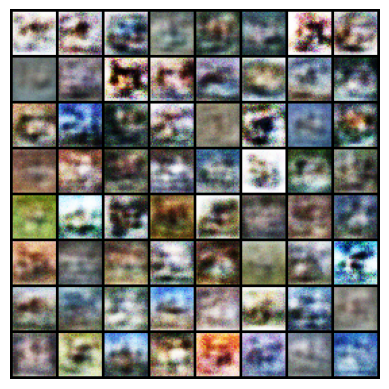

In [65]:
import matplotlib.pyplot as plt

# Generate random noise and use the generator to produce images
z = torch.randn(64, z_dim)
generated_imgs = generator(z).view(-1, 3, 32, 32)

# Create a grid of the generated images
grid_img = torchvision.utils.make_grid(generated_imgs, nrow=8, padding=2, normalize=True)

# Display the images
plt.imshow(grid_img.permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')
plt.axis('off')
plt.show()